In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### accuracy along each linear axis, in each task

In [5]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            # actual labels for position along this axis
            coord_actual = pt_labs[:,ii]
            # actual category along this axis
            categ_actual = np.array(l['categ_task%d'%(ii+1)])
    
            dist_from_center = np.array(l['dist_from_bound%d'%(ii+1)]).round(1)
            # hard trials are closest to bound (variable grid)
            # easy is the furthest from bound
            # medium is second furthest
            is_hard = dist_from_center<0.8
            is_easy = (dist_from_center==2.4) & is_main_grid
            is_medium = (dist_from_center==0.8) & is_main_grid
           
            is_correct = np.array(l['subject_correct'])
            
            for ri in range(n_rois):

                # switching categs here so that 1=coord<center, 2=coord>center
                categ_pred = 3-dec_withintask['preds_all'][si][ri][ti][ii].astype(int)
             
                prob = dec_withintask['probs_all'][si][ri][ti][ii]
                
                p_categ1 = prob[:,1]
                p_categ2 = prob[:,0]
                
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

    
                # all trials
                inds = is_main_grid & is_correct
            
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_easy & is_correct
                
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium & is_correct
                
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                

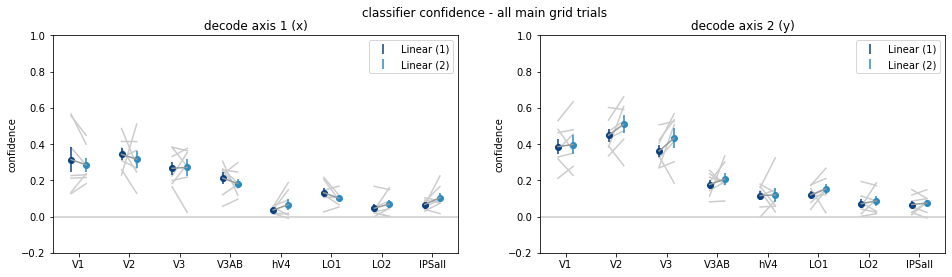

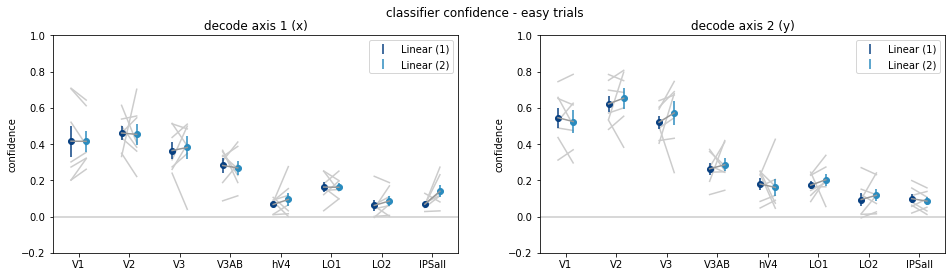

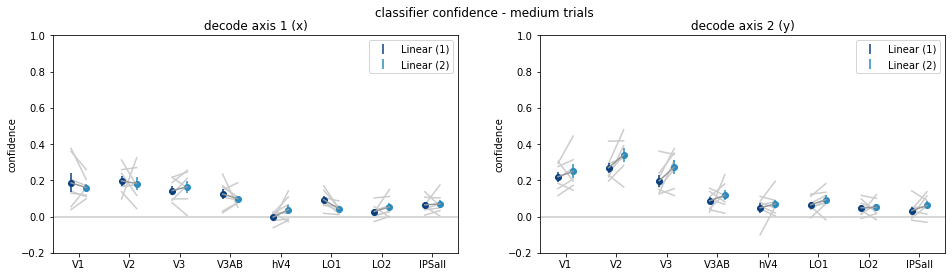

In [7]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

for rvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.2, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('classifier confidence - %s'%name)


In [8]:
# Just compare the two "linear" tasks here
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = np.concatenate([copy.deepcopy(conf_easytrials[:,:,0:2,ii:ii+1]), \
                           copy.deepcopy(conf_medtrials[:,:,0:2,ii:ii+1])], axis=3)

    anova_table =  stats_utils.rmanova_3way(vals, ['roi','task','distance'], do_shuffle=False)                            
    
    anova_table['Pr > F'] = anova_table['Pr > F'].round(4)
    
    print('Classify %s'%axis_name)
    
    print(anova_table)

Classify axis 1 (x)
                      F Value  Num DF  Den DF  Pr > F
roi                 20.306694     7.0    42.0  0.0000
task                 0.187925     1.0     6.0  0.6798
distance           211.823085     1.0     6.0  0.0000
roi:task             0.594141     7.0    42.0  0.7570
roi:distance        27.273749     7.0    42.0  0.0000
task:distance        9.451393     1.0     6.0  0.0218
roi:task:distance    0.898849     7.0    42.0  0.5164
Classify axis 2 (y)
                      F Value  Num DF  Den DF  Pr > F
roi                 54.224500     7.0    42.0  0.0000
task                 3.971646     1.0     6.0  0.0933
distance           198.215348     1.0     6.0  0.0000
roi:task             0.444821     7.0    42.0  0.8680
roi:distance        55.694926     7.0    42.0  0.0000
task:distance        6.042904     1.0     6.0  0.0492
roi:task:distance    0.902345     7.0    42.0  0.5138


In [9]:
for cvals, diffname in zip([conf_easytrials, conf_medtrials], \
                        ['easy','medium']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)
        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        print('Classify %s, %s trials'%(axis_name, diffname))
        print(anova_result)


Classify axis 1 (x), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       23.592524     7.0    42.0  0.0000
task       0.939945     1.0     6.0  0.3697
roi:task   0.404772     7.0    42.0  0.8940
Classify axis 2 (y), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       64.912049     7.0    42.0  0.0000
task       0.690316     1.0     6.0  0.4379
roi:task   0.407837     7.0    42.0  0.8921
Classify axis 1 (x), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       13.001101     7.0    42.0  0.0000
task       0.052361     1.0     6.0  0.8266
roi:task   1.178918     7.0    42.0  0.3354
Classify axis 2 (y), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       31.251149     7.0    42.0  0.0000
task      13.515063     1.0     6.0  0.0104
roi:task   0.710620     7.0    42.0  0.6632


In [10]:
ii = 1;
vals = copy.deepcopy(conf_medtrials[:,:,0:2,ii])

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 234534
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0]
    t2_values = vals[:,rr,1]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

p_values = pvals_nonpar_task
  
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                           'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,-0.971,0.322,5
V2,-2.110,0.077,6
V3,-2.368,0.092,5
V3AB,-0.855,0.463,4
hV4,-0.731,0.501,4
LO1,-1.473,0.179,6
LO2,-0.074,0.938,4
IPSall,-1.166,0.284,4


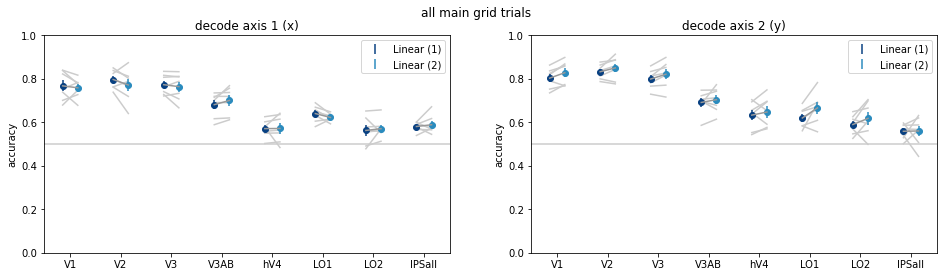

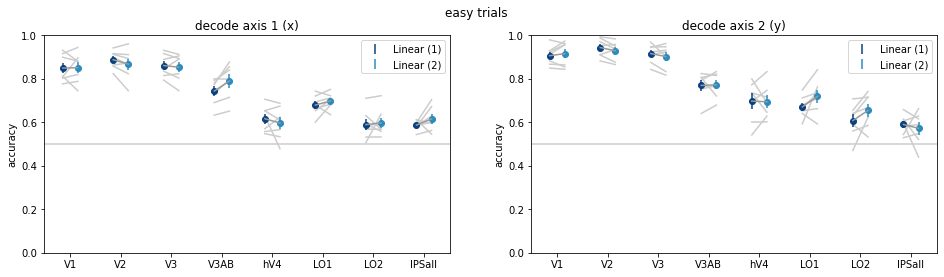

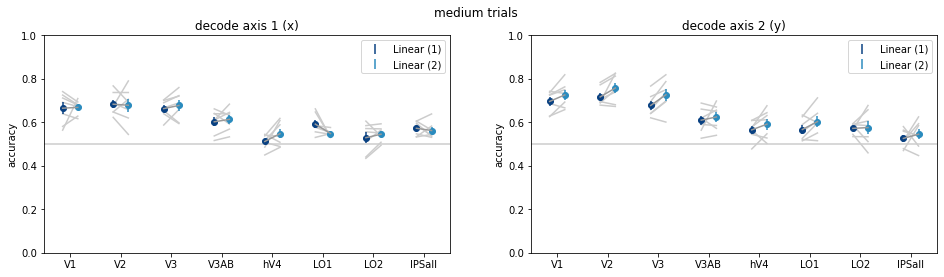

In [9]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

for rvals, name in zip([acc_allmaintrials, acc_easytrials, acc_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(1/2, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6])

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([0, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('accuracy')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('%s'%name)


#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

In [14]:
n_coord_bins = 12;
coord_bin_edges = np.linspace(2.5-0.801, 2.5+0.801, n_coord_bins+1)
center=2.5
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = (center-bin_centers).round(2)

n_boot_iter = 1000;
# n_boot_iter = 2;
n_boot_samp = 100;


dprime_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

signedconf_hardtrials_sepcorrect_boot = np.zeros((n_subjects, n_rois, 2, 2, n_boot_iter))

for si, ss in enumerate(subjects):

    print(si)
    
    for ti, tt in enumerate([1,2]):
        
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1

        ii = ti; # focusing on the task-relevant axis here
        
        # is it a hard trial?
        is_hard = ~is_main_grid
        
        categ_actual = np.array(l['categ_task%d'%(tt)])
        
        coord_actual = pt_labs[:,ii].round(2)
        
        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))
        
        
        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct)[0]
        inds2 = np.where(is_hard & ~correct)[0]
        
        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        print(un1, counts1)
        print(un2, counts2)
    
        print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]
                
        print(bin_dist[bins_balance])
        
        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)
        
        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))
        # print(bins_balance)
        
        # loop over correct/incorrect trials
        for ci, inds in enumerate([inds1, inds2]):

            nt = len(inds)
            
            for bi in range(n_boot_iter):

                # make a resampling order that represents each bin equally
                inds_resamp = []
                for bn in bins_balance:
                    inds_bin = inds[coord_binned[inds]==bn]
                    assert(len(inds_bin)>0)
                    if bi==0:
                        print(len(inds_bin), n_samp_eachbin)
                    inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
                inds_resamp = np.concatenate(inds_resamp, axis=0)
                
                # check that the set we created has half each category
                assert(np.mean(categ_actual[inds_resamp]==1)==0.5)
                
                # double check resample order
                assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
                counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
                assert(np.all(counts==n_samp_eachbin))
                
                # get predictions from each ROI, these trials
                for ri in range(n_rois):

                    # switching categs here so that 1=coord<center, 2=coord>center
                    categ_pred = 3-dec_withintask['preds_all'][si][ri][ti][ii].astype(int)

                    prob = dec_withintask['probs_all'][si][ri][ti][ii]

                    p_categ1 = prob[:,1]
                    p_categ2 = prob[:,0]
                    
                    # signed confidence will be: p(correct) - p(incorrect)
                    signedconf = np.zeros_like(p_categ1)
                    signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                    signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

                    d = stats_utils.get_dprime(categ_pred[inds_resamp], categ_actual[inds_resamp])
                    dprime_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = d

                    signedconf_hardtrials_sepcorrect_boot[si,ri,ti,ci,bi] = np.mean(signedconf[inds_resamp])



0
[2 3 4 5 6 7 8 9] [ 8 26 30  7  7 14 11  3]
[3 4 5 6 7 8 9] [ 6 10  9  9 26 21  5]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
26 17
30 17
7 17
7 17
14 17
11 17
6 17
10 17
9 17
9 17
26 17
21 17
[3 4 5 6 7 8] [ 8 14 30 26 24 14]
[3 4 5 6 7 8] [ 8 18 18 22  8  2]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33] [ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
[ 0.33  0.2   0.07 -0.07 -0.2  -0.33]
8 17
14 17
30 17
26 17
24 17
14 17
8 17
18 17
18 17
22 17
8 17
2 17
1
[2 3 4 5 6 7 8 9] [ 6 27 11  2  7 26 37  7]
[2 3 4 5 6 7 8 9] [ 2 21 21  6  1  6 11  1]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47] [ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
[ 0.47  0.33  0.2   0.07 -0.07 -0.2  -0.33 -0.47]
6 13
27 13
11 13
2 13
7 13
26 13
37 13
7 13
2 13
21 13
21 13
6 13
1 13
6 13
11 13
1 13
[2 3 4 7 8 9] [11 23  9 21 43 11]
[2 3 4 7 8 9] [ 5 33 15  3 13  5]
[ 0.47  0.33  0.2  -0.2  -0.33 -0.47] [ 0.47  0.33  0.2  -0.2  -0.33 -0

Text(0.5, 0.98, 'Hard trials: classifier confidence, median +/- bootstrapped 95 CI')

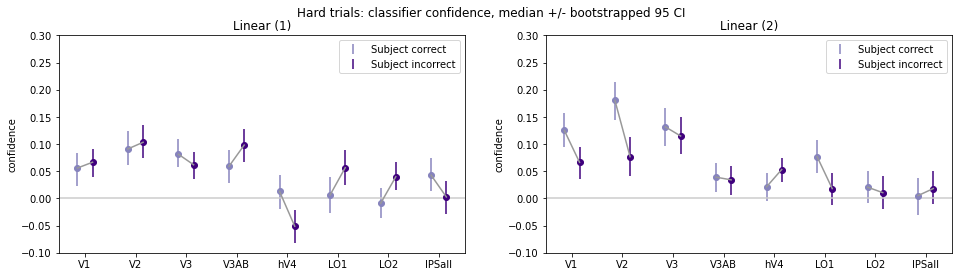

In [15]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([signedconf_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    signedconf_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-0.1, 0.3])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Hard trials: classifier confidence, median +/- bootstrapped 95 CI')


Text(0.5, 0.98, 'Hard trials: dprime, median +/- bootstrapped 95 CI')

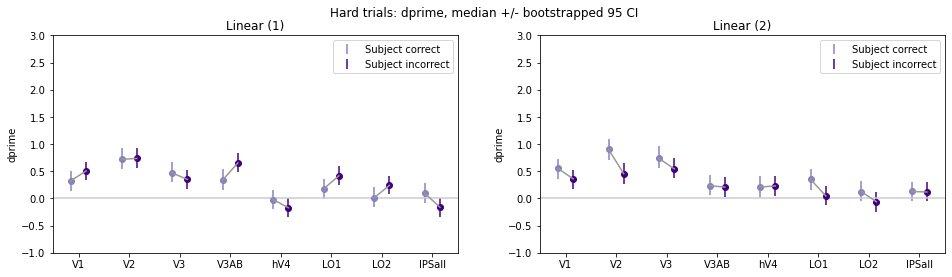

In [16]:
x_jitter = [-0.15, 0.15]

plt.figure(figsize=(16,4))
    
for ti, tt in enumerate([1,2]):
   
    plt.subplot(1,2,tt)
    
    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    mtmp = []
    for ci, boot_vals in enumerate([dprime_hardtrials_sepcorrect_boot[:,:,ti,0], \
                                    dprime_hardtrials_sepcorrect_boot[:,:,ti,1]]):
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        # average over subjects (within each bootstrapping iteration)
        boot_vals_avg = np.mean(boot_vals, axis=0)
        boot_pct = np.percentile(boot_vals_avg, [2.5, 50, 97.5], axis=1)
           
        # get percentiles of the bootstrapped distrib
        median_vals = boot_pct[1]
        mtmp.append(median_vals)
        lower_vals = median_vals - boot_pct[0]
        upper_vals = boot_pct[2] - median_vals
        
        plt.plot(x_ticks, median_vals, 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, median_vals, np.array([lower_vals, upper_vals]), xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        median_vals = [mtmp[0][ri], mtmp[1][ri]]
        plt.plot([ri+x_jitter[0], ri+x_jitter[1]], median_vals,'-',color=[0.6, 0.6, 0.6])

    plt.ylim([-1, 3])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('dprime')
    
    plt.legend(lh,['Subject correct','Subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Hard trials: dprime, median +/- bootstrapped 95 CI')
